#**Практическое задание №1**

Установка необходимых пакетов:

In [ ]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Монтирование Вашего Google Drive к текущему окружению:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [ ]:
EVALUATE_ONLY = True
TRAIN_FIRST = False
TRAIN_SECOND = False
TRAIN_SVM = False
TEST_SECOND = False
TEST_VOTING = False
TEST_ON_LARGE_DATASET = True
TRAIN_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi&confirm=t',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR&confirm=t',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui&confirm=t',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr&confirm=t',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI&confirm=t',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc&confirm=t'
}

Импорт необходимых зависимостей:

In [ ]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import tensorflow as tf
from matplotlib import pyplot as plt
import joblib

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [ ]:
PROJECT_DIR = 'IntroductionToNeuralNetworks/First/'

class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        p = Path("/content/drive/MyDrive/" + PROJECT_DIR + name + '.npz') 
        if p.exists():
            print(f'Loading dataset {self.name} from npz.')
            np_obj = np.load(str(p))
            self.images = np_obj['data']
            self.labels = np_obj['labels']
            self.n_files = self.images.shape[0]
            self.is_loaded = True
            print(f'Done. Dataset {name} consists of {self.n_files} images.')
        self.indexes = np.arange(self.n_files)

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
  
    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        self.batch_with_labels_by_indexes(n, indices)

    def batch_with_labels_by_indexes(self, indices):
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

In [ ]:
class DataGenerator(tf.keras.utils.Sequence): 
    'Generates data for Keras'
    def __init__(self, dataset, batch_size=32, mode="test", percent=0.9):
        'Initialization'
        self.dataset = dataset
        self.mode = mode
        self.percent = percent
        if mode == "test":
            self.batch_size = batch_size
        else:
            self.batch_size = int(np.floor(self.dataset.n_files * self.percent))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.dataset.n_files / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        if self.mode == "test":
            indexes = self.dataset.indexes[index*self.batch_size:(index+1)*self.batch_size]
        else:
            indexes = self.dataset.indexes[-self.batch_size:]
        X, y = self.dataset.batch_with_labels_by_indexes(indexes)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        np.random.shuffle(self.dataset.indexes)


In [ ]:
def split_generators(dataset, batch_size=32, percent=0.9):
    train_gen = DataGenerator(dataset, batch_size=batch_size, percent=percent)
    validation_gen = DataGenerator(dataset, batch_size=batch_size, mode="validation", percent=(1 - percent))
    return train_gen, validation_gen

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 0.
Label code corresponds to ADI class.


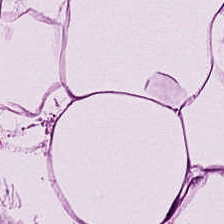

In [ ]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

In [ ]:
if TEST_ON_LARGE_DATASET: # Initialize datasets
    d_test = Dataset("test")
else:
    d_test = Dataset("test_small")

if TRAIN_ON_LARGE_DATASET:
    d_train = Dataset("train")
else:
    d_train = Dataset("train_small")

Loading dataset test from npz.
Done. Dataset test consists of 4500 images.
Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

    @staticmethod
    def confusion_matrix(gt: List[int], pred: List[int]): #VTP visualisation of confusion matrix
        cm = confusion_matrix(gt, pred)
        cm_display = ConfusionMatrixDisplay(cm).plot()

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [ ]:
!pip install tensorflow_addons

import tensorflow as tf
import tensorflow_addons as tfa


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class Model:

    def __init__(self, model=None):
        self.model = model
        
    def load(self):
        url = f'https://drive.google.com/drive/folders/1gnWje_Czf2ACtrcHtas7yKgY2b4ha6iv?usp=sharing'
        gdown.download_folder(url, quiet=False, use_cookies=False)

    def test_on_dataset(self, dataset: Dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions


## Модели основанные на нейронных сетях

Так как от поворота/освещения наши 

In [ ]:
data_augmentation = tf.keras.Sequential([ 
    tf.keras.layers.RandomFlip("horizontal", input_shape=(224,224,3)),
    tf.keras.layers.RandomRotation(1),
]) #DA - data augmentation

In [ ]:

class ModelNeural(Model):
    
    def __init__(self, architecture, augmentation=data_augmentation, optimizer="adam"):
      
      self.model = tf.keras.Sequential([
          augmentation,#DA - data augmentation
          tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
          architecture
      ])

      self.model.compile(
          optimizer=optimizer,
          loss=tf.losses.SparseCategoricalCrossentropy(),
          metrics=['accuracy'])
  
    def save(self, name):
        self.model.save(f'/content/drive/MyDrive/IntroductionToNeuralNetworks/First/Models/{name}.tfile')

    
    def load(self, name, download_all=True):
        if download_all:
            super().load()
        name = f'/content/Models/{name}.tfile'
        self.model = tf.keras.models.load_model(name)
      
    def train(self, dataset, epochs_num=15, batch_size=32):
        self.epochs_num = epochs_num
        print(f'training started')
        train_gen, val_gen = split_generators(dataset, batch_size=batch_size, percent=0.99)
        self.history = self.model.fit(train_gen, validation_data=val_gen, epochs=epochs_num) #V/P_DL - validation and printing during learning
        print(f'training done')

    def test_on_image(self, img: np.ndarray):
        img = img.reshape((1, *img.shape))
        probabilities = self.model.predict(img, verbose=0)
        prediction = np.argmax((probabilities[0]))
        return prediction

    def visualise(self): #VLP visualisation of learning process (neural)

        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']

        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs_range = range(self.epochs_num)

        plt.figure(figsize=(8, 8))
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.show()


### Первая модель


Взята из примера классификации картинок из гайда по Tenserflow

In [ ]:
first_architecture = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(TISSUE_CLASSES), activation="softmax")
])

In [ ]:
model = ModelNeural(first_architecture)

In [ ]:
if TRAIN_FIRST:
    model.train(d_train, epochs_num=15, batch_size=32, )
    model.save("first")
else:
    model.load("first")

training started
Epoch 1/15
562/562 [==============================] - 69s 69ms/step - loss: 1.3283 - accuracy: 0.4901 - val_loss: 1.0577 - val_accuracy: 0.6000
Epoch 2/15
562/562 [==============================] - 37s 66ms/step - loss: 0.8129 - accuracy: 0.6922 - val_loss: 0.6011 - val_accuracy: 0.7556
Epoch 3/15
562/562 [==============================] - 37s 65ms/step - loss: 0.6399 - accuracy: 0.7702 - val_loss: 0.5757 - val_accuracy: 0.7556
Epoch 4/15
562/562 [==============================] - 37s 66ms/step - loss: 0.5354 - accuracy: 0.8063 - val_loss: 0.4449 - val_accuracy: 0.8444
Epoch 5/15
562/562 [==============================] - 37s 66ms/step - loss: 0.4916 - accuracy: 0.8204 - val_loss: 0.3931 - val_accuracy: 0.8389
Epoch 6/15
562/562 [==============================] - 41s 73ms/step - loss: 0.4437 - accuracy: 0.8397 - val_loss: 0.4023 - val_accuracy: 0.8722
Epoch 7/15
562/562 [==============================] - 37s 66ms/step - loss: 0.4042 - accuracy: 0.8551 - val_loss: 0.275

In [ ]:
pred_1 = model.test_on_dataset(d_test)

  0%|          | 0/4500 [00:00<?, ?it/s]

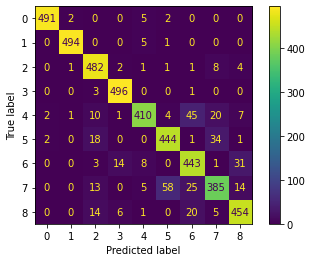

In [ ]:
Metrics.confusion_matrix(d_test.labels, pred_1)

In [ ]:
Metrics.accuracy(d_test.labels, pred_1)

0.9108888888888889

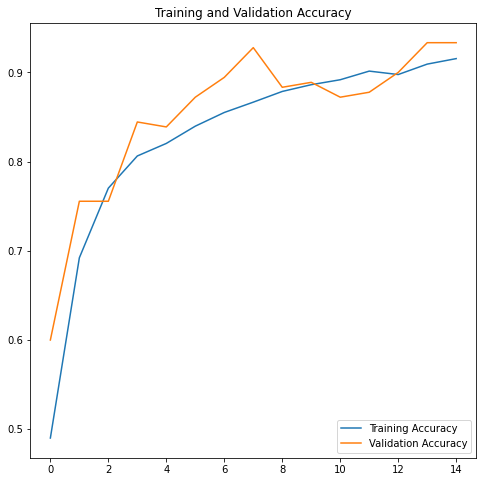

In [ ]:
if TRAIN_FIRST:
    model.visualise()

In [ ]:
model.model.layers[2].summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 32)      

### Вторая модель


Реализована архитектура предложенная в статье "Improved convolutional neural network based histopathological image classification" (https://doi.org/10.1007/s12065-020-00367-y).

Сначала я попытался реализовать её используя оптимизатор Adam, однако тогда качество получаемой модели застревало в локальном минимуме функции потерь. Поэтому я решил использовать оптимизатор RectifiedAdam.

In [ ]:
def complex_conv_layer(number_of_filters, drop_out_rate, pool_size):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(number_of_filters, 3, padding="same", activation="relu"),
        tf.keras.layers.Conv2D(number_of_filters, 3, padding="same", activation="relu"),
        tf.keras.layers.Conv2D(number_of_filters, 3, padding="same", activation="relu"),
        tf.keras.layers.Conv2D(number_of_filters, 3, padding="same", activation="relu"),
        tf.keras.layers.Dropout(drop_out_rate),
        tf.keras.layers.MaxPooling2D(pool_size=pool_size)
    ])


second_architecture = tf.keras.Sequential([
    complex_conv_layer(16, 0.3, 3),
    complex_conv_layer(32, 0.2, 3),
    complex_conv_layer(64, 0.1, 3),
    complex_conv_layer(128, 0.05, 3),
    complex_conv_layer(256, 0.05, 2),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(len(TISSUE_CLASSES), activation="softmax")
])


In [ ]:
second_model = ModelNeural(second_architecture, optimizer=tfa.optimizers.RectifiedAdam())

In [ ]:
second_model.model.layers[2].summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 74, 74, 16)        7408      
                                                                 
 sequential_15 (Sequential)  (None, 24, 24, 32)        32384     
                                                                 
 sequential_16 (Sequential)  (None, 8, 8, 64)          129280    
                                                                 
 sequential_17 (Sequential)  (None, 2, 2, 128)         516608    
                                                                 
 sequential_18 (Sequential)  (None, 1, 1, 256)         2065408   
                                                                 
 flatten_4 (Flatten)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 9)               

In [ ]:
if TRAIN_SECOND:
    second_model.train(d_train, epochs_num=15, batch_size=128)
    second_model.save("second")
else:
    second_model.load("second", download_all=False)

training started
Epoch 1/15
140/140 [==============================] - 90s 620ms/step - loss: 1.9140 - accuracy: 0.2388 - val_loss: 2.0649 - val_accuracy: 0.1778
Epoch 2/15
140/140 [==============================] - 84s 599ms/step - loss: 1.4041 - accuracy: 0.4292 - val_loss: 2.0004 - val_accuracy: 0.2389
Epoch 3/15
140/140 [==============================] - 84s 598ms/step - loss: 1.2702 - accuracy: 0.4816 - val_loss: 1.2511 - val_accuracy: 0.5500
Epoch 4/15
140/140 [==============================] - 84s 602ms/step - loss: 1.2036 - accuracy: 0.5185 - val_loss: 1.8886 - val_accuracy: 0.3778
Epoch 5/15
140/140 [==============================] - 84s 602ms/step - loss: 1.0780 - accuracy: 0.5737 - val_loss: 1.7264 - val_accuracy: 0.4889
Epoch 6/15
140/140 [==============================] - 84s 598ms/step - loss: 0.9490 - accuracy: 0.6274 - val_loss: 1.2645 - val_accuracy: 0.5000
Epoch 7/15
140/140 [==============================] - 84s 600ms/step - loss: 0.8539 - accuracy: 0.6624 - val_loss

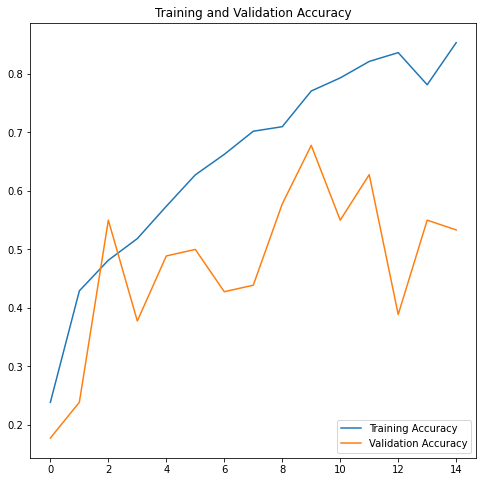

In [ ]:
if TRAIN_SECOND:
    second_model.visualise()

In [ ]:
if TEST_SECOND:
    pred_2 = second_model.test_on_dataset(d_test)

  0%|          | 0/4500 [00:00<?, ?it/s]

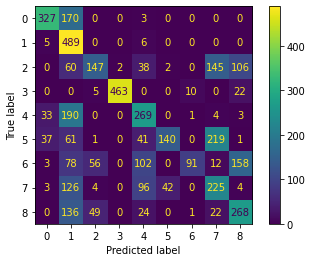

In [ ]:
if TEST_SECOND:
    Metrics.confusion_matrix(d_test.labels, pred_2)

Обучить эту модель не получилось...

## Обычные модели

### Третья модель

Модель SVM обученная на Local Binary Patterns признаках.

In [ ]:
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score


In [ ]:
def get_lbp_features(image, n_points=8, radius=1):
    image = rgb2gray(image)
    lbp = local_binary_pattern(image, n_points, radius)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    return hist

In [ ]:
def get_features(image, n_points=8, radius=1):
    image = rgb2gray(image)
    lbp = local_binary_pattern(image, n_points, radius)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    return hist

In [ ]:
class ModelSVM(Model):

    def __init__(self, preprocessing=get_lbp_features, kernel="rbf"):
        self.C = 1
        self.gamma = 0.7
        self.model = svm.SVC(kernel=kernel, C=self.C, gamma=self.gamma)
        self.preprocessing = preprocessing

    def save(self, name):
        joblib.dump(self.model, f'/content/drive/MyDrive/IntroductionToNeuralNetworks/First/Models/{name}.joblib')

    def load(self, name, download_all=True):
        if download_all:
            super().load()
        self.model = joblib.load(f'/content/Models/{name}.joblib')

    def find_best_params(self, dataset): #AHC automatically find best hyperparameters
        self.X, self.y = dataset.batch_with_labels_by_indexes(dataset.indexes)
        self.X = np.array([self.preprocessing(image) for image in self.X])
        C = np.logspace(-2, 5, 40)
        gamma = np.random.uniform(low=0.2, high=1.2, size=10)
        searcher = RandomizedSearchCV(svm.SVC(kernel="rbf"), [{"C": C, "gamma": gamma}], n_iter=40, scoring="accuracy", cv=10, verbose=1)
        searcher.fit(self.X, self.y)
        self.C = searcher.best_params_["C"]
        self.gamma = searcher.best_params_["gamma"]
        self.model = svm.SVC(kernel="rbf", C=self.C, gamma=self.gamma)
        print(f"Found best parameters: C (regularization rate) = {self.C}, gamma = {self.gamma}")

    def train(self, dataset):
        self.X, self.y = dataset.batch_with_labels_by_indexes(dataset.indexes)
        self.X = np.array([self.preprocessing(image) for image in self.X])
        print("training started!")
        self.model.fit(self.X, self.y)
        print("training complete!")

    def test_on_image(self, image, **kwargs):
        x_test = self.preprocessing(image).reshape(1, -1)
        return self.model.predict(x_test)[0]

In [ ]:
model_svm = ModelSVM()

In [ ]:
if TRAIN_SVM:
    model_svm.find_best_params(d_train_tiny)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Found best parameters: C (regularization rate) = 8376.776400682924, gamma = 1.1061087620819738


In [ ]:
if TRAIN_SVM:
    model_svm.train(d_train)
    model_svm.save("svm")
else:
    model_svm.load("svm", download_all=False)

training started!
training complete!


In [ ]:
pred_svm = model_svm.test_on_dataset(d_test)

  0%|          | 0/4500 [00:00<?, ?it/s]

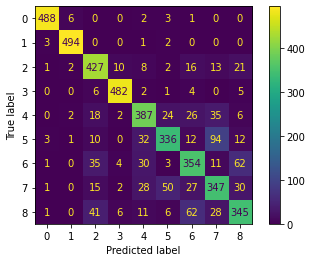

In [ ]:
Metrics.confusion_matrix(d_test.labels, pred_svm)

In [ ]:
Metrics.accuracy(d_test.labels, pred_svm)

0.8133333333333334

## Общая модель

Модель принятия решения голосованием.

In [ ]:
class ModelVoting(Model):
    def __init__(self, *models):
        self.models = models
    

    def train(self, dataset):
        for model in self.models:
            model.train(dataset)

    def load(self, names, download_all=True):
        for i, model in enumerate(self.models):
            model.load(names[i], download_all=download_all)

    def save(self, names):
        for i, model in enumerate(self.models):
            model.load(names[i])

    def test_on_image(self, image, **kwargs):
        predictions = []
        for model in self.models:
            predictions.append(model.test_on_image(image))
        return max(set(predictions), key=predictions.count)


In [ ]:
if TEST_VOTING:
    model_vote = ModelVoting(ModelNeural(first_architecture), ModelNeural(second_architecture), ModelSVM())
    model_vote.load(["first", "second", "svm"], download_all=False)
    pred_vote = model_vote.test_on_dataset(d_test)

  0%|          | 0/4500 [00:00<?, ?it/s]

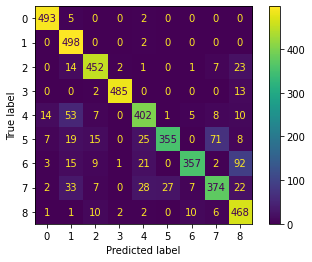

In [ ]:
if TEST_VOTING:
    Metrics.confusion_matrix(d_test.labels, pred_vote)

In [ ]:
if TEST_VOTING:
    Metrics.accuracy(d_test.labels, pred_vote)

0.8631111111111112

Такая архитектура не сильно изменила качество.

---
## Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [ ]:
model = ModelNeural(first_architecture)
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save("first")
else:
    model.load('first')

Retrieving folder list


Processing file 1-u0cv7Cp7Wh7kesIqseD1WN2zQSPFzrA best.joblib
Retrieving folder 1-5dIhepOXPGutOKF2Xkcej1zp3Arfvfr best.tfile
Retrieving folder 1-HLHhoCGgetJj9fa3i8lj05y6tZIcBYT assets
Processing file 1-651JSEn62K_G0AMOQVVPlbIKpGn7Z3Z keras_metadata.pb
Processing file 1-BefrZpYxH6YGKDATxM2Xj7xxuMb0JOo saved_model.pb
Retrieving folder 1-PvLO5oiauO7ixaL6BQBrh674mhkl7k4 variables
Processing file 1-Tnc8tb7cUrK4EOSDA6d9DK3F32XVZNl variables.data-00000-of-00001
Processing file 1-VRbJOvtsQKvIHpXilF5dsfhj8AZxKFF variables.index
Retrieving folder 1ZK-I4xmsFzwpdPmoJbldj7V3gL-crpv9 first.tfile
Retrieving folder 1-6R0roBL2dDH1q_r3IMUr0h8cw6CYDlF assets
Processing file 1-0P0zrn4UoxlrmPbF1T6kxXKTSWijCun keras_metadata.pb
Processing file 1-1Iu62DThY4sB8bVPyutdEp5qHP-88IW saved_model.pb
Retrieving folder 1-Lz0zGvMFooK5bsa9yH-XGFPhplUSCCx variables
Processing file 1-MWRfn9NgRzgjEspYKYzMshX3DAodJWF variables.data-00000-of-00001
Processing file 1-Vleh23qT_IEDH9AoBvqa8ymGTa3lLUT variables.index
Retrieving 

Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1-u0cv7Cp7Wh7kesIqseD1WN2zQSPFzrA
To: /content/Models/best.joblib
100%|██████████| 14.4M/14.4M [00:00<00:00, 163MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-651JSEn62K_G0AMOQVVPlbIKpGn7Z3Z
To: /content/Models/best.tfile/keras_metadata.pb
100%|██████████| 33.5k/33.5k [00:00<00:00, 45.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-BefrZpYxH6YGKDATxM2Xj7xxuMb0JOo
To: /content/Models/best.tfile/saved_model.pb
100%|██████████| 453k/453k [00:00<00:00, 100MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Tnc8tb7cUrK4EOSDA6d9DK3F32XVZNl
To: /content/Models/best.tfile/variables/variables.data-00000-of-00001
100%|██████████| 1.37M/1.37M [00:00<00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-VRbJOvtsQKvIHpXilF5dsfhj8AZxKFF
To: /content/Models/best.tfile/variables/variables.index
100%|██████████| 2.54k/2.54k [00:00<00:00, 1.3

Пример тестирования модели на части набора данных:

In [ ]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

  0%|          | 0/450 [00:00<?, ?it/s]

metrics for 10% of test:
	 accuracy 0.9800:
	 balanced accuracy 0.9800:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Пример тестирования модели на полном наборе данных:

  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for test:
	 accuracy 0.9109:
	 balanced accuracy 0.9109:


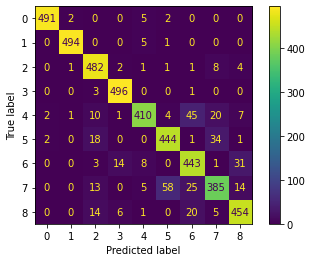

In [ ]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')
    Metrics.confusion_matrix(d_test.labels, pred_2)

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [ ]:
final_model = ModelSVM()
final_model.load('svm')
d_test_tiny = Dataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Downloading...
From: https://drive.google.com/uc?id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc&confirm=t
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:02<00:00, 5.03MB/s]

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.8111:
	 balanced accuracy 0.8111:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899


Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  4  5  0]
 [ 0  0  0  0 88  0  0  0  0  4]
 [

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


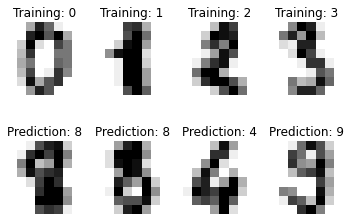

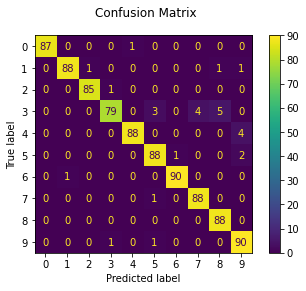

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

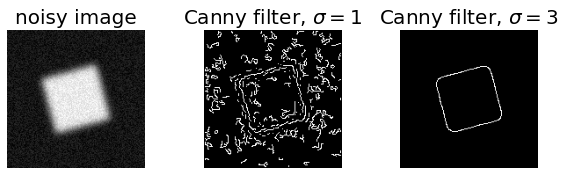

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
tf.keras.models.Sequential.evaluate?

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3001 - accuracy: 0.9126
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1468 - accuracy: 0.9563
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1107 - accuracy: 0.9663
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0915 - accuracy: 0.9722
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0760 - accuracy: 0.9764
313/313 - 1s - loss: 0.0767 - accuracy: 0.9751 - 629ms/epoch - 2ms/step


[0.07665158063173294, 0.9750999808311462]

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru. 

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb 

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"